# Medicare Clustering 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import string
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Data Cleaning

### Loading Only Necessary Columns

In [2]:
# Renaming column names & Grabbing relevant columns
columns = ['npi', 'last_name', 'first_name', 'middle_initial', 'credentials',
           'gender', 'entity_code', 'street_1,', 'street_2', 'city', 'zip',
           'state', 'country', 'provider_type', 'medicare_participation_indicator',
           'place_of_service', 'hcpcs_code', 'hcpcs_desc', 'hcps_drug', 'services_count',
           'unique_patients_count', 'unique_patients_day_count', 'average_allowed_amount',
           'average_submitted_charge', 'average_medicare_payment',
           'average_medicare_payment_standardized']

relevant_columns = ['credentials', 'entity_code', 'city', 'state', 'country', 'provider_type',
                    'services_count', 'unique_patients_count', 'unique_patients_day_count',
                    'average_allowed_amount', 'average_submitted_charge', 'average_medicare_payment',
                    'average_medicare_payment_standardized']

relevant_numerical_columns = relevant_columns[6:]

df = pd.read_csv('CY2017.txt', sep="\t", header=0, skiprows=1, names=columns,
                 usecols=relevant_columns)
rows = df.shape[0]

### Removing Outliers from Numerical Data

In [3]:
def drop_numerical_outliers(df, z_thresh=4):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, result_type='reduce') \
        .all(axis=1)
    df.drop(df.index[~constrains], inplace=True)

drop_numerical_outliers(df)

In [18]:
# Percentage of samples are removed by dropping outliers 
percent_removed = round((rows - df.shape[0])/rows * 100, 2)
print(f'{percent_removed}% of data points have been removed')

1.09% of data points have been removed


### Addressing 0-values for Log Transformations

In [5]:
# Function to replace 0-values with adjusted means for log graphing
def zero_remover(df, col):
    avg = df[col][df[col] > 0].mean()
    df.loc[df[col] == 0, col] = avg

# Apply function to these two columns 
zero_remover(df, 'average_medicare_payment')
zero_remover(df, 'average_medicare_payment_standardized')

## Exploratory Data Analysis 

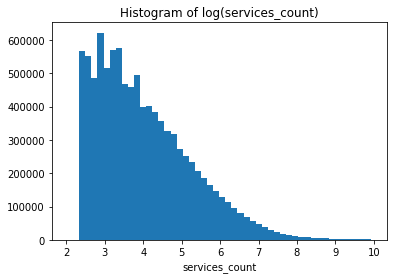

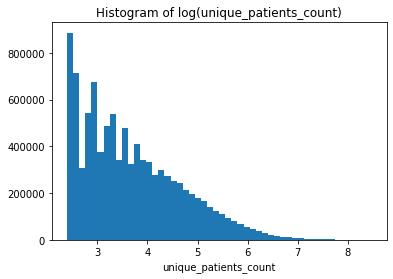

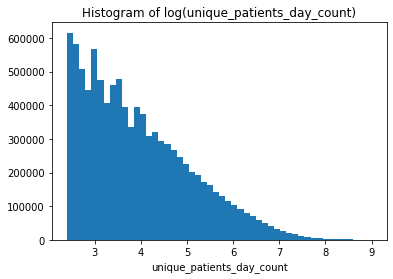

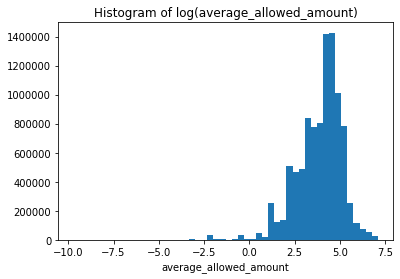

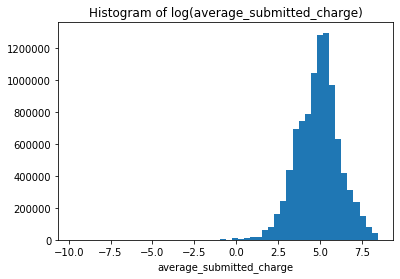

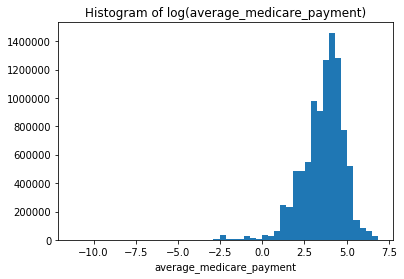

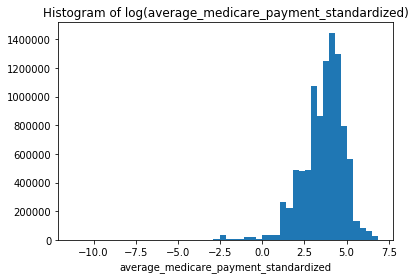

In [6]:
# Function to plot histograms for columns
def plotter(x, df):
    plt.hist(np.log(df[x]), bins=50, log=False)
    plt.xlabel(x)
    #plt.title('Histogram of ' + x)
    plt.title('Histogram of log(' + x + ')')
    plt.show()

# Plot each column
for i in relevant_numerical_columns:
    plotter(i, df)


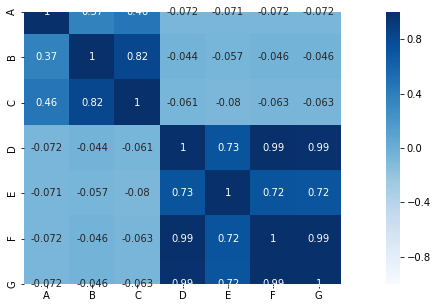

In [7]:
# Create a correlation heatmap for numerical columns
corr = df[relevant_numerical_columns].corr()
tick = list(string.ascii_uppercase[0:7])
plt.figure(figsize=(16, 5))
sns.heatmap(corr, xticklabels=tick, yticklabels=tick, square=True, vmin=-1, vmax=1, annot=corr, cmap ='Blues')
plt.show()

## Clustering 

In [8]:
#Todo execute clustering algorithm while considering time issues -- think of problem first and then think of
# what subset of data to cluster on 
print(df[['average_allowed_amount']])

         average_allowed_amount
0                     73.398800
1                    100.080000
2                    136.380000
3                    190.363729
4                    101.680000
...                         ...
9847438              116.860000
9847439              203.400000
9847440               72.480000
9847441              104.760000
9847442              107.980000

[9740242 rows x 1 columns]


### Standardize Data of Interest

In [22]:
scaler = StandardScaler()
std_df = df[['average_allowed_amount', 'average_submitted_charge', 'average_medicare_payment_standardized']]
scaler.fit(std_df)
std_df = scaler.transform(std_df)

[ 87.43765161 284.0286714   67.13606735]
[[-0.13386172  0.09135457 -0.11763201]
 [ 0.12054593  0.36096781  0.1484489 ]
 [ 0.46666971  0.72199835  0.44838466]
 ...
 [-0.14262256 -0.23637364 -0.11888107]
 [ 0.16517015 -0.06570465  0.18680304]
 [ 0.19587314 -0.04820014  0.22448842]]


### Determine Number of Clusters

In [31]:
maxClusters = 30
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(std_df)
    sse.append(kmeans.inertia_)

KeyboardInterrupt: 

In [27]:
print(sse)
plt.plot(range(2,maxClusters),sse)

NameError: name 'sse' is not defined